# ExternalSource operator

In this example, we will see how to use `ExternalSource` operator which allows us to
use an external data source as an input to the Pipeline.

In [1]:
import types
import collections
import numpy as np
from random import shuffle
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops            
import nvidia.dali.types as types

batch_size = 16

### Defining the data source
In this example, we use an infinite iterator as a data source.

In [2]:
class ExternalInputIterator(object):
    def __init__(self, batch_size):
        self.images_dir = "../../data/images/"
        self.batch_size = batch_size
        with open(self.images_dir + "file_list.txt", 'r') as f:
            self.files = [line.rstrip() for line in f if line is not '']
        shuffle(self.files)

    def __iter__(self):
        self.i = 0
        self.n = len(self.files)
        return self

    def __next__(self):
        batch = []
        labels = []
        for _ in range(self.batch_size):
            jpeg_filename, label = self.files[self.i].split(' ')
            f = open(self.images_dir + jpeg_filename, 'rb')
            batch.append(np.frombuffer(f.read(), dtype = np.uint8))
            labels.append(np.array([label], dtype = np.uint8))
            self.i = (self.i + 1) % self.n
        return (batch, labels)


### Defining the pipeline

The next step is to define the Pipeline.

The `ExternalSource` operator accepts an iterable or a callable. If the source provides multiple outputs (e.g. images and labels), that number must also be specified as `num_output` argument.

Internally, the pipeline will call `source` (if callable) or run `next(source)` (if iterable) whenever more data is needed to keep the pipeline running.

In [3]:
eii = ExternalInputIterator(batch_size)

In [4]:
 class ExternalSourcePipeline(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(ExternalSourcePipeline, self).__init__(batch_size,
                                      num_threads,
                                      device_id,
                                      seed=12)
        
        self.source = ops.ExternalSource(source = eii, num_outputs = 2)
        self.decode = ops.ImageDecoder(device = "mixed", output_type = types.RGB)
        self.enhance = ops.BrightnessContrast(device = "gpu", contrast = 2)

    def define_graph(self):                                                                
        jpegs, labels = self.source()
        images = self.decode(jpegs)
        output = self.enhance(images)
        return (output, labels)

### Using the pipeline

In [5]:
pipe = ExternalSourcePipeline(batch_size=batch_size, num_threads=2, device_id = 0)
pipe.build()                                                        
pipe_out = pipe.run()

Notice that labels are still on CPU and no as_cpu call is needed to show them.

In [6]:
batch_cpu = pipe_out[0].as_cpu()
labels_cpu = pipe_out[1]

(427, 640, 3)
[1]


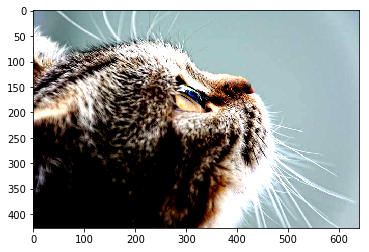

In [8]:
from __future__ import print_function
import matplotlib.pyplot as plt
img = batch_cpu.at(2)
print(img.shape)
print(labels_cpu.at(2))
plt.imshow(img)